# Simple CNN for PETALO

Esta red la vamos a utilizar para obtener el radio 

In [34]:
import numpy as np
#np.random.seed(1337)  # for reproducibility
from time import time
from datetime import datetime
# from sklearn import preprocessing
import sys

sys.path.append("/home/rgadea/lmfit-py/")
sys.path.append("/home/rgadea/experimentos/viherbos/")

print(sys.path)
import json 

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# import seaborn as sns
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras import regularizers
from keras.optimizers import Adam, Nadam, RMSprop, SGD
from math import floor
from lmfit.models import  GaussianModel
import matplotlib.pyplot as plt

['/home/rgadea/anaconda3/envs/tensorflow3/lib/python36.zip', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/lib-dynload', '', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/IPython/extensions', '/volumedisk0/home/rgadea/.ipython', '/home/rgadea/lmfit-py/', '/home/rgadea/experimentos/viherbos/', '/home/rgadea/lmfit-py/', '/home/rgadea/experimentos/viherbos/', '/home/rgadea/lmfit-py/', '/home/rgadea/experimentos/viherbos/']


In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
import tensorflow as tf
print(tf.__version__)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

1.13.1


## Vamos introducir los datos de petalo preprocesados en pyhton


## Network parameters:

In [3]:
npzfile = np.load('../conjuntos_datos_nuevos_2020/11_12_2019.npz')
npzfile.files

# conjunto_datos_entradasA=npzfile['arr_0']
# conjunto_datos_entradasB=npzfile['arr_1']
# conjunto_datos_salidas=npzfile['arr_2']
entradas_sensorsA1=npzfile['arr_0']
entradas_sensorsB1=npzfile['arr_1']
coordenadas1=npzfile['arr_2']
entradas_sensorsA2=npzfile['arr_3']
entradas_sensorsB2=npzfile['arr_4']
coordenadas2=npzfile['arr_5']

conjunto_datos_entradasA=np.concatenate((entradas_sensorsA1,entradas_sensorsA2),axis=0)
conjunto_datos_entradasB=np.concatenate((entradas_sensorsB1,entradas_sensorsB2),axis=0)
conjunto_datos_salidas=np.concatenate((coordenadas1,coordenadas2),axis=0)


print('conjunto_datos_entradas A shape:', conjunto_datos_entradasA.shape)
print('conjunto_datos_entradas B shape:', conjunto_datos_entradasB.shape)
print('conjunto_datos_salidas shape:', conjunto_datos_salidas.shape)

conjunto_datos_entradas A shape: (68002, 20, 175)
conjunto_datos_entradas B shape: (68002, 20, 175)
conjunto_datos_salidas shape: (68002, 3)


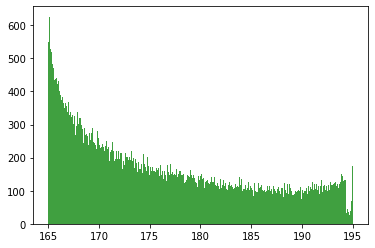

In [4]:
n, bins, patches = plt.hist(conjunto_datos_salidas[:,0], 400, density=0, facecolor='green', alpha=0.75)

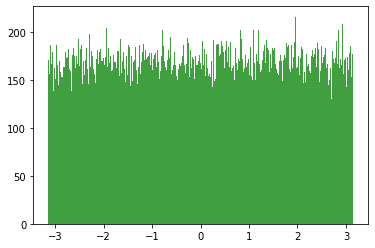

In [5]:
n, bins, patches = plt.hist(conjunto_datos_salidas[:,1], 400, density=0, facecolor='green', alpha=0.75)

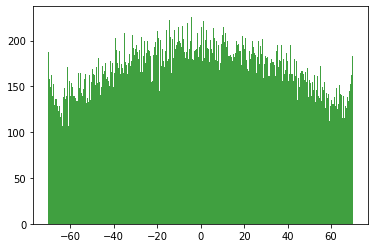

In [6]:
n, bins, patches = plt.hist(conjunto_datos_salidas[:,2], 400, density=0, facecolor='green', alpha=0.75)

In [7]:
batch_size = 250
nb_classes = 10
nb_epoch = 2000

# input image dimensions
img_rows, img_cols = 20, 41
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (4, 4)

## Prepare data into training and test set.

In [8]:
muestras=conjunto_datos_entradasA.shape[0]
# veamos=idea.reshape(idea.shape[0],175, 20)


veamos2=np.zeros([muestras,20,175])
veamos2_3=np.zeros([muestras,20,525])
sector2A=np.zeros([muestras,20,img_cols])
sector2B=np.zeros([muestras,20,img_cols])
veamos3=np.zeros([muestras,175])
# for i in range(idea.shape[0]):
for i in range(muestras):
    veamos2[i]=conjunto_datos_entradasA[i]
    veamos3[i]=np.sum(veamos2[i], axis=0)
    indice=np.argmax(veamos3[i], axis=0)
    veamos2_3[i]=np.concatenate((veamos2[i],veamos2[i],veamos2[i]),axis=1) 
    indice_inferior=int(indice-((img_cols-1)/2)+175)
    indice_superior=int(indice+((img_cols+1)/2)+175)
    sector2A[i]=veamos2_3[i,:,indice_inferior:indice_superior]
for i in range(muestras):
    veamos2[i]=conjunto_datos_entradasB[i]
    veamos3[i]=np.sum(veamos2[i], axis=0)
    indice=np.argmax(veamos3[i], axis=0)
    veamos2_3[i]=np.concatenate((veamos2[i],veamos2[i],veamos2[i]),axis=1) 
    indice_inferior=int(indice-((img_cols-1)/2)+175)
    indice_superior=int(indice+((img_cols+1)/2)+175)
    sector2B[i]=veamos2_3[i,:,indice_inferior:indice_superior]    

print('sector A shape:', sector2A.shape)
conjunto_datos_nuevoA=sector2A.reshape(sector2A.shape[0], img_rows*img_cols)
print('conjunto_datos_nuevo A:', conjunto_datos_nuevoA.shape)

print('sector B shape:', sector2B.shape)
conjunto_datos_nuevoB=sector2B.reshape(sector2B.shape[0], img_rows*img_cols)
print('conjunto_datos_nuevo B:', conjunto_datos_nuevoB.shape)

sector A shape: (68002, 20, 41)
conjunto_datos_nuevo A: (68002, 820)
sector B shape: (68002, 20, 41)
conjunto_datos_nuevo B: (68002, 820)


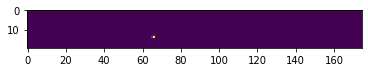

-134.958529690526


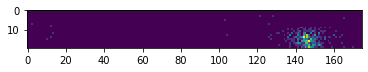

29.844130523415945


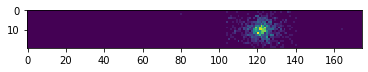

-19.395014937798578


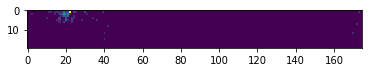

130.2927668024486


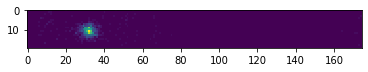

155.39107416232588


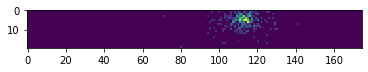

-38.300799840078724


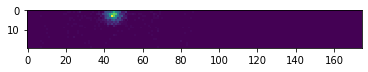

-177.7960323322737


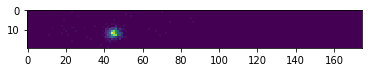

-177.71822122120116


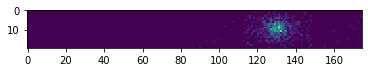

-1.4759675249715638


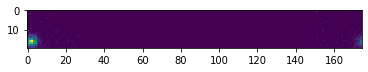

93.22332370133361


In [9]:
for i in range(1,11):
    idea=np.random.randint(1,conjunto_datos_entradasB.shape[0])
    plt.imshow(conjunto_datos_entradasB[idea], cmap='viridis')
    plt.show()
    print(conjunto_datos_salidas[idea,1]*180/np.pi)

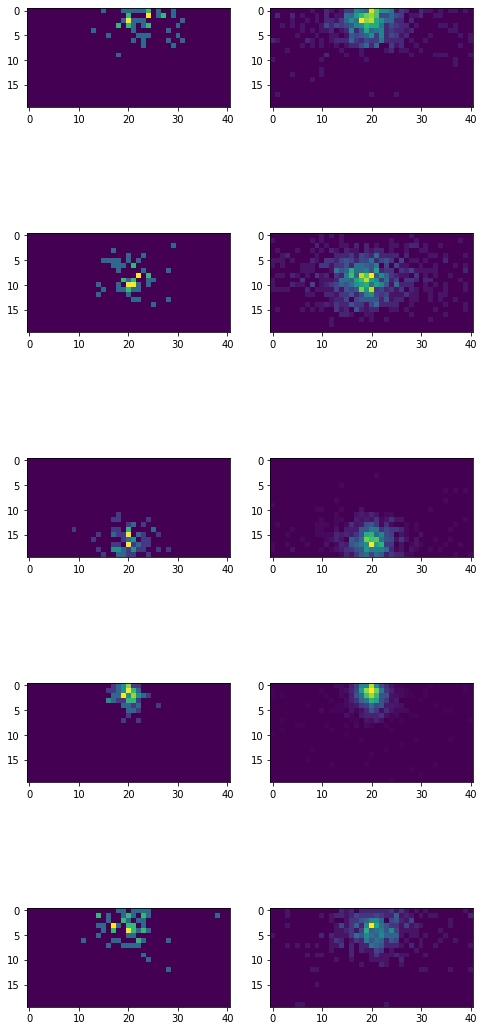

In [10]:
n = 5  # how many digits we will display

fig = plt.figure(figsize=(8,20))

for i in range(n):
    # display original
    ideas=np.random.randint(1,muestras)
    ax = fig.add_subplot(n, 2, (i)*2+1)
    plt.imshow(sector2A[ideas], cmap='viridis')
    plt.viridis()

    # display reconstruction
    ax = fig.add_subplot(n, 2, (i)*2+2)
    plt.imshow(sector2B[ideas], cmap='viridis')
    plt.viridis()

plt.show()

# print(x_test[idea])
# print(decoded_imgs[idea])
# print(decoded_imgs_scaled[idea])


In [11]:
numero_muestras=muestras
tr_size=60
val_size=20
test_size=100-val_size-tr_size
conjunto_datos_nuevo2=np.concatenate((conjunto_datos_salidas,conjunto_datos_nuevoB), axis=1)
print (conjunto_datos_nuevo2.shape)
tamanyo_tr=floor(tr_size*numero_muestras/100)
tamanyo_val=floor(val_size*numero_muestras/100)
tamanyo_test=numero_muestras-tamanyo_tr-tamanyo_val
print(tamanyo_tr)
print(tamanyo_val)
print(tamanyo_test)


XY_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,:]


XY_test_bin0=XY_test[np.where((XY_test[:,0]>=164.9999) * (XY_test[:,0]<171.000))]
XY_test_bin1=XY_test[np.where((XY_test[:,0]>=171.000) * (XY_test[:,0]<177.000))]
XY_test_bin2=XY_test[np.where((XY_test[:,0]>=177.000) * (XY_test[:,0]<183.0000))]
XY_test_bin3=XY_test[np.where((XY_test[:,0]>=183.000) * (XY_test[:,0]<189.0000))]
XY_test_bin4=XY_test[np.where((XY_test[:,0]>=189.0000))]

X_train=conjunto_datos_nuevo2[:tamanyo_tr,3:]
X_val=conjunto_datos_nuevo2[tamanyo_tr:tamanyo_tr+tamanyo_val,3:]
X_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,3:]

X_test_bin0=XY_test_bin0[:,3:]
Y_test_bin0=XY_test_bin0[:,0]
print(X_test_bin0.shape)
X_test_bin1=XY_test_bin1[:,3:]
Y_test_bin1=XY_test_bin1[:,0]
print(X_test_bin1.shape)
X_test_bin2=XY_test_bin2[:,3:]
Y_test_bin2=XY_test_bin2[:,0]
print(X_test_bin2.shape)
X_test_bin3=XY_test_bin3[:,3:]
Y_test_bin3=XY_test_bin3[:,0]
print(X_test_bin3.shape)
X_test_bin4=XY_test_bin4[:,3:]
Y_test_bin4=XY_test_bin4[:,0]
print(X_test_bin4.shape)



Y_train=conjunto_datos_nuevo2[:tamanyo_tr,0] #elijo la coordenada radius
Y_val=conjunto_datos_nuevo2[tamanyo_tr:tamanyo_tr+tamanyo_val,0] #elijo la corrdenada radius
Y_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,0] #elijo la corrdenada radius

(68002, 823)
40801
13600
13601
(5161, 820)
(2890, 820)
(2197, 820)
(1718, 820)
(1635, 820)


In [12]:


X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols,1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols,1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

X_test_bin0 = X_test_bin0.reshape(X_test_bin0.shape[0], img_rows, img_cols,1)
X_test_bin1 = X_test_bin1.reshape(X_test_bin1.shape[0], img_rows, img_cols,1)
X_test_bin2 = X_test_bin2.reshape(X_test_bin2.shape[0], img_rows, img_cols,1)
X_test_bin3 = X_test_bin3.reshape(X_test_bin3.shape[0], img_rows, img_cols,1)
X_test_bin4 = X_test_bin4.reshape(X_test_bin4.shape[0], img_rows, img_cols,1)

input_shape = (img_rows, img_cols,1)
#input_shape=input_shape.astype('int32')

In [13]:
X_train = X_train.astype('float32')
X_val= X_val.astype('float32')
X_test = X_test.astype('float32')

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

X_train shape: (40801, 20, 41, 1)
40801 train samples
13600 validation samples
13601 test samples


Display 20 random training images using image

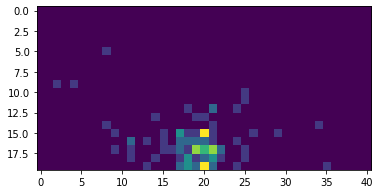

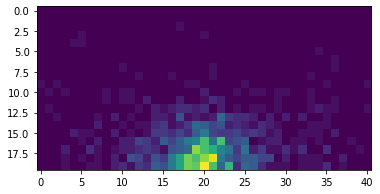

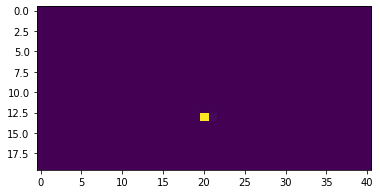

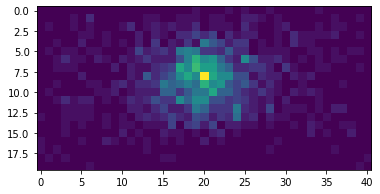

In [14]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,X_train.shape[0])
    plt.imshow(np.reshape(X_train[idea], [img_rows, img_cols]), cmap='viridis')
    plt.show()

## Build the CNN. 

In [42]:
model = Sequential()

model.add(Conv2D(8, kernel_size=kernel_size,
                        padding='same',
                        input_shape=(img_rows,img_cols,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Conv2D(16, kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Conv2D(32, kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, kernel_size, padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(128, kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1))

dt = datetime.now().replace(second=0, microsecond=0)
experimento="CNN_kernel_{}x{}_con_batchnormalization_sector_{}x{}x{}".format(kernel_size[0],kernel_size[1],img_rows,img_cols,1)
algoritmo='Nadam'
optimizador=Nadam(beta_1=0.9, beta_2=0.999)

tensorboard=TensorBoard(log_dir="../logs/defs/{}{}{}".format(experimento,algoritmo,dt))
model_check=ModelCheckpoint('../redes_CNN_R/models_best/CNN_regression_R_{}_{}_{}_{}_{}.h5'.format(nb_epoch,batch_size,experimento,algoritmo,dt), monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', period=1)
early_stop=EarlyStopping(monitor='val_loss', min_delta=0, patience=500, verbose=2, mode='auto', baseline=None)
model.compile(loss='mean_squared_error',
              optimizer=optimizador)



Show a summary of the model parameters. 

In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 20, 41, 8)         136       
_________________________________________________________________
batch_normalization_25 (Batc (None, 20, 41, 8)         32        
_________________________________________________________________
activation_31 (Activation)   (None, 20, 41, 8)         0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 10, 20, 8)         0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 10, 20, 16)        2064      
_________________________________________________________________
batch_normalization_26 (Batc (None, 10, 20, 16)        64        
_________________________________________________________________
activation_32 (Activation)   (None, 10, 20, 16)        0         
__________

And now train the model and evaluate on the test set. 

In [ ]:
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch,
          verbose=1, validation_data=(X_val, Y_val),
                    callbacks=[tensorboard,model_check,early_stop])

Train on 40801 samples, validate on 13600 samples
Epoch 1/2000
40801/40801 [==============================] - 4s 87us/step - loss: 1489.0768 - val_loss: 237.4563

Epoch 00001: val_loss improved from inf to 237.45630, saving model to ../redes_CNN_R/models_best/CNN_regression_R_2000_250_CNN_kernel_4x4_con_batchnormalization_sector_20x41x1_Nadam_2019-12-16 09:31:00.h5
Epoch 2/2000
40801/40801 [==============================] - 2s 59us/step - loss: 25.4743 - val_loss: 48.2116

Epoch 00002: val_loss improved from 237.45630 to 48.21165, saving model to ../redes_CNN_R/models_best/CNN_regression_R_2000_250_CNN_kernel_4x4_con_batchnormalization_sector_20x41x1_Nadam_2019-12-16 09:31:00.h5
Epoch 3/2000
40801/40801 [==============================] - 2s 59us/step - loss: 22.7655 - val_loss: 94.5402

Epoch 00003: val_loss did not improve from 48.21165
Epoch 4/2000
40801/40801 [==============================] - 2s 59us/step - loss: 21.7138 - val_loss: 67.5281

Epoch 00004: val_loss did not improve fr

In [19]:

model.save_weights('../redes_CNN_R/defs/CNN_regression_R_{}_{}_{}_{}_{}'.format(nb_epoch,batch_size,experimento,algoritmo,dt))

In [20]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test mse:', score)
# print('Test mae:', score[1])
Y_test_predicted=model.predict(X_test)
print(Y_test_predicted[:10].flatten())
print(Y_test[:10])
error_prediction=Y_test-Y_test_predicted.flatten()

print(error_prediction[:10])

Test mse: 15.918245779276859
[186.45956 176.32977 176.39369 191.24484 171.26149 192.67462 175.01814
 180.12044 178.62326 185.7092 ]
[186.49503655 173.92123133 178.72558252 192.94521119 171.90670897
 189.65895825 165.62569864 181.49123072 175.97967042 167.91610503]
[  0.03547234  -2.40854162   2.33189051   1.70036866   0.6452191
  -3.01566333  -9.39244406   1.3707931   -2.64359007 -17.79309296]


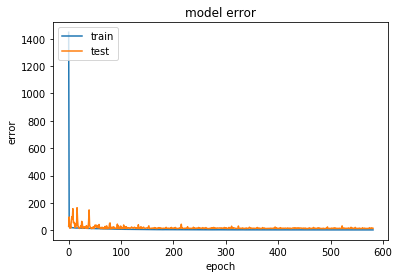

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
#print(error_prediction)

/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


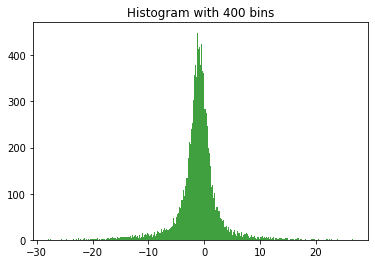

(400,)
(401,)
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 400
    # variables        = 3
    chi-square         = 70443.7451
    reduced chi-square = 177.440164
    Akaike info crit   = 2074.44207
    Bayesian info crit = 2086.41647
[[Variables]]
    amp:  392.073810 +/- 3.59507615 (0.92%) (init = 1000)
    cen: -0.99081194 +/- 0.01677098 (1.69%) (init = 0)
    wid:  2.23998034 +/- 0.02371775 (1.06%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = -0.577



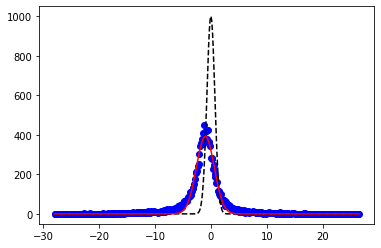

In [23]:

n, bins, patches = plt.hist(error_prediction, 400, normed=0, facecolor='green', alpha=0.75)
plt.title("Histogram with 400 bins")
plt.show()
x=bins[:400]
y=n
print(n.shape)
print(bins.shape)
from numpy import exp, loadtxt, pi, sqrt, log

from lmfit import Model
def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return amp * exp(-((x-cen)/wid)**2 )


gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)

print(result.fit_report())

plt.plot(x, y, 'bo')
plt.plot(x, result.init_fit, 'k--')
plt.plot(x, result.best_fit, 'r-')
plt.show()





In [24]:
FWHM=result.params['wid'].value*2*sqrt(log(2))

In [25]:
print(FWHM)

3.7298119276446493


/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


2.8883380455354346


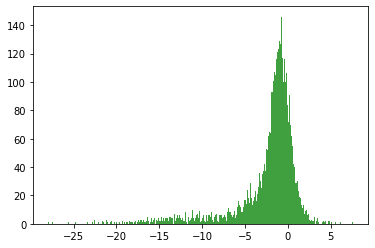

In [26]:
Y_test_bin0_predicted=model.predict(X_test_bin0)
# print(Y_test_bin0_predicted)
error_prediction_bin0=Y_test_bin0-Y_test_bin0_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin0, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin0=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin0)

/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


4.628224684876187


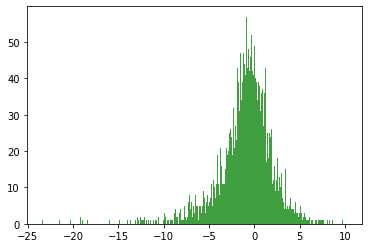

In [27]:
Y_test_bin1_predicted=model.predict(X_test_bin1)
#print(Y_test_bin1_predicted)
error_prediction_bin1=Y_test_bin1-Y_test_bin1_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin1, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin1=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin1)

/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


4.838211404450795


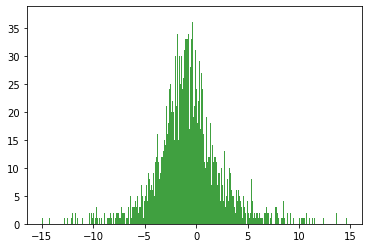

In [28]:
Y_test_bin2_predicted=model.predict(X_test_bin2)
#print(Y_test_bin2_predicted)
error_prediction_bin2=Y_test_bin2-Y_test_bin2_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin2, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin2=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin2)

/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


3.8730173957611442


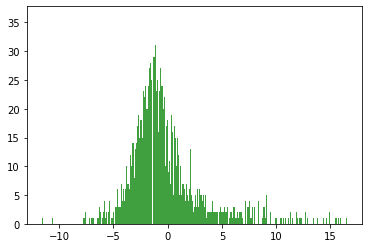

In [29]:
Y_test_bin3_predicted=model.predict(X_test_bin3)
#print(Y_test_bin3_predicted)
error_prediction_bin3=Y_test_bin3-Y_test_bin3_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin3, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin3=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin3)

/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


3.7724403875926953
3.8730173957611442
4.838211404450795
4.628224684876187
2.8883380455354346


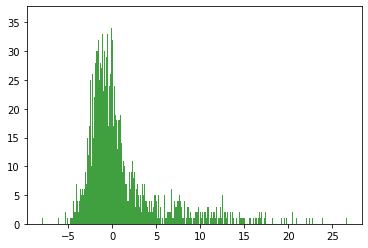

In [30]:
Y_test_bin4_predicted=model.predict(X_test_bin4)
#print(Y_test_bin4_predicted)
error_prediction_bin4=Y_test_bin4-Y_test_bin4_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin4, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin4=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin4)
print(FWHM_bin3)
print(FWHM_bin2)
print(FWHM_bin1)
print(FWHM_bin0)

Veamos ahora los histogramnas 2d que nos interesan